<a href="https://colab.research.google.com/github/Kairory/ML-python_study/blob/main/%D0%93%D0%BB%D0%B0%D0%B2%D0%B0_6_%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B8_%D1%80%D0%B0%D0%B7%D0%B2%D1%91%D1%80%D1%82%D1%8B%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BE%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import tensorflow as tf
import tensorflow_hub as hub

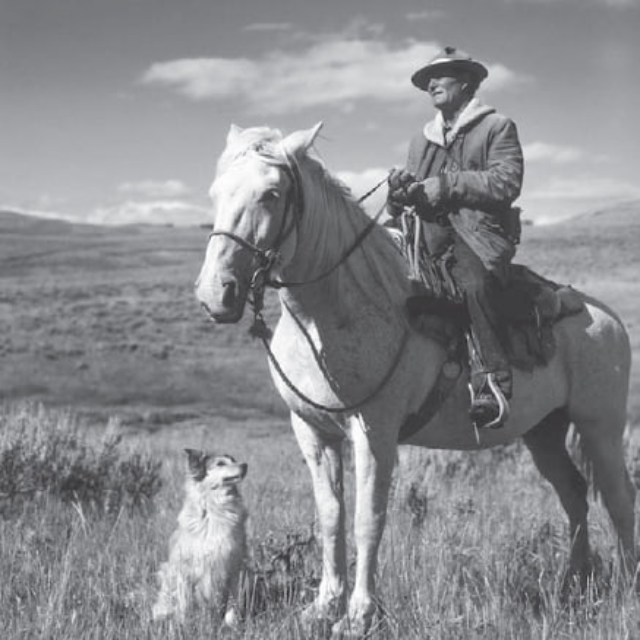

(640, 640, 3)

In [2]:
img = cv2.imread("horse.jpg")
img = cv2.resize(img, dsize=(640, 640))
cv2_imshow(img)
img.shape

In [3]:
img = np.expand_dims(img, 0)
img.shape

(1, 640, 640, 3)

# SSD (Single Shot Multibox Detector)

## MobileNets

In [4]:
hub_url = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1"
object_detector = hub.KerasLayer(hub_url)

In [5]:
def create_model(object_detector):
    img_input = tf.keras.Input(shape=(None, None, 3), dtype=tf.uint8)
    #outputs = object_detector(img_input) при этом способе выходит ошибка входных данных
    #tf.cast преобразует тип данных x в tf.uint8, а лямбда слой позволяет создать такой слой
    outputs = tf.keras.layers.Lambda(lambda x: object_detector(tf.cast(x, tf.uint8)))(img_input)
    model = tf.keras.Model(inputs=img_input, outputs=outputs)
    return model

In [6]:
model = create_model(object_detector)
detector_output = model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [7]:
list(detector_output.keys())

['raw_detection_boxes',
 'detection_multiclass_scores',
 'detection_classes',
 'detection_boxes',
 'raw_detection_scores',
 'num_detections',
 'detection_anchor_indices',
 'detection_scores']

In [8]:
!wget -qq https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_complete_label_map.pbtxt

In [9]:
def get_labels(file):
    labels = list()
    with open(file, "r") as file:
        for line in file:
            if "display_name" in line:
                labels.append(line.split('"')[1])
    return labels

In [10]:
LABELS = get_labels("mscoco_complete_label_map.pbtxt")
BB_COLORS = np.random.randint(0, 255, size=(len(LABELS), 3))

In [11]:
def draw_bounding_boxes(img, output, colors, labels):
    bounding_boxes = output["detection_boxes"][0].shape[0]
    (H, W) = img.shape[1], img.shape[2]

    for i in range(bounding_boxes):
        confidence = output["detection_scores"][0][i]

        if confidence > 0.5:
            ymin, xmin, ymax, xmax = output["detection_boxes"][0][i]
            class_id = int(output["detection_classes"][0][i])

            color = [int(c) for c in colors[class_id]]

            cv2.rectangle(
                img[0],
                (round(xmin*W), round(ymin*H)),
                (round(xmax*W), round(ymax*H)),
                color,
                2
            )

            text = f"{labels[class_id]}: {confidence:.4f}"
            cv2.putText(
                img[0],
                text,
                (round((xmin*W)), round(ymin*H) - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                color,
                2
            )

    return img

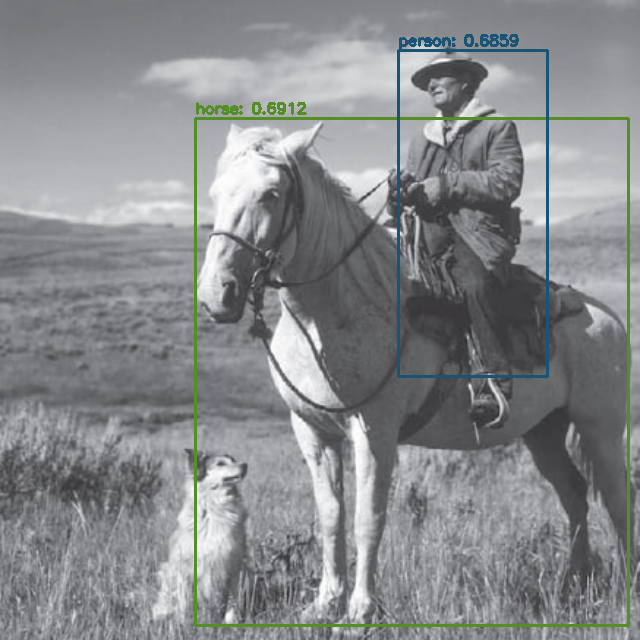

In [12]:
output_img = draw_bounding_boxes(img, detector_output, BB_COLORS, LABELS)
cv2_imshow(output_img[0])

In [13]:
import time

start_time = time.time()
detector_output = model.predict(img)

print(f"Time required to predict: {time.time() - start_time} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Time required to predict: 0.7189686298370361 seconds


## ResNet

In [14]:
hub_url = "https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1"
object_detector = tf.keras.layers.Lambda(lambda x: hub.KerasLayer(hub_url)(tf.cast(x, tf.uint8)))

In [15]:
def create_model(object_detector):
    img_input = tf.keras.Input(shape=(None, None, 3), dtype=tf.uint8)
    outputs = object_detector(img_input)
    model = tf.keras.Model(inputs=img_input, outputs=outputs)
    return model

In [16]:
model = create_model(object_detector)

In [17]:
start_time = time.time()
detector_output = model.predict(img)

print(f"Time required to predict: {time.time() - start_time} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step
Time required to predict: 42.600506067276 seconds


# R-CNN (Regional-based Convolutional Neural Network)

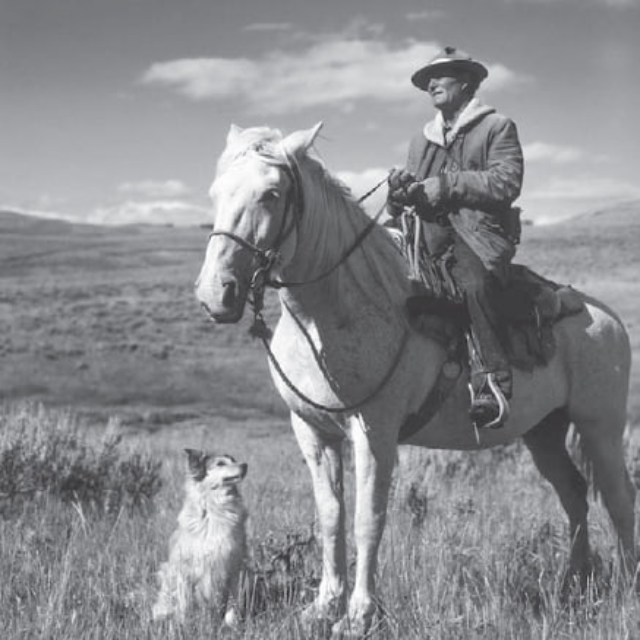

(1, 640, 640, 3)

In [26]:
img = cv2.imread("horse.jpg")
img = cv2.resize(img, dsize=(640, 640))
cv2_imshow(img)
img = np.expand_dims(img, 0)
img.shape

In [27]:
hub_url = "https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1"
object_detector = tf.keras.layers.Lambda(lambda x: hub.KerasLayer(hub_url)(tf.cast(x, tf.uint8)))

model = create_model(object_detector)
detector_output = model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step


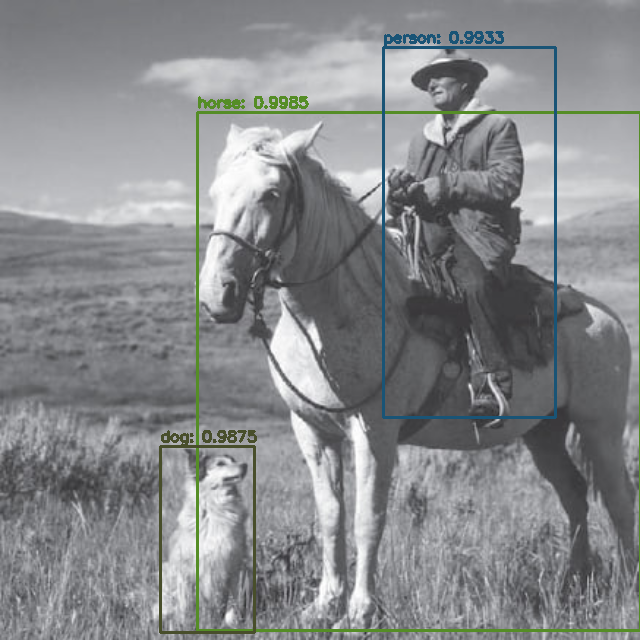

In [28]:
output_img = draw_bounding_boxes(img, detector_output, BB_COLORS, LABELS)
cv2_imshow(output_img[0])

In [29]:
import time

start_time = time.time()
detector_output = model.predict(img)

print(f"Time required to predict: {time.time() - start_time} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Time required to predict: 5.32520866394043 seconds


Загрузка модели из архива

In [30]:
!wget -qq http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz

In [31]:
!tar -zxvf faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz

faster_rcnn_resnet101_v1_640x640_coco17_tpu-8/
faster_rcnn_resnet101_v1_640x640_coco17_tpu-8/checkpoint/
faster_rcnn_resnet101_v1_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
faster_rcnn_resnet101_v1_640x640_coco17_tpu-8/checkpoint/checkpoint
faster_rcnn_resnet101_v1_640x640_coco17_tpu-8/checkpoint/ckpt-0.index
faster_rcnn_resnet101_v1_640x640_coco17_tpu-8/pipeline.config
faster_rcnn_resnet101_v1_640x640_coco17_tpu-8/saved_model/
faster_rcnn_resnet101_v1_640x640_coco17_tpu-8/saved_model/saved_model.pb
faster_rcnn_resnet101_v1_640x640_coco17_tpu-8/saved_model/variables/
faster_rcnn_resnet101_v1_640x640_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
faster_rcnn_resnet101_v1_640x640_coco17_tpu-8/saved_model/variables/variables.index


In [32]:
saved_model = tf.saved_model.load("/content/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8/saved_model")
object_detector = tf.keras.layers.Lambda(lambda x: hub.KerasLayer(saved_model)(tf.cast(x, tf.uint8)))

model = create_model(object_detector)

# YOLO (You Only Look Once)

In [33]:
!wget -qq https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget -qq https://pjreddie.com/media/files/yolov3.weights

In [34]:
!wget -qq https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

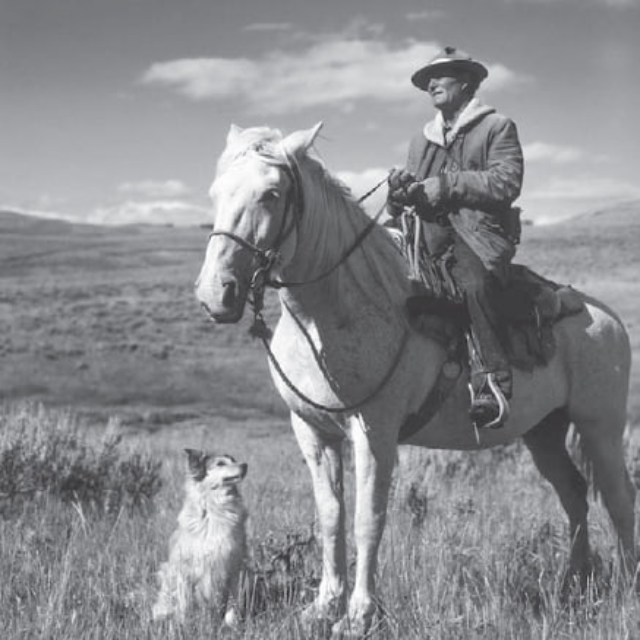

In [46]:
img = cv2.imread("horse.jpg")
img = cv2.resize(img, dsize=(640, 640))
cv2_imshow(img)

In [47]:
LABELS = list()
with open("/content/coco.names", "r") as file:
    for line in file:
        LABELS.append(line.strip())

In [48]:
model = cv2.dnn.readNetFromDarknet("yolov3.cfg", "yolov3.weights")

In [49]:
prep_img = img/255.0
prep_img = prep_img.transpose(2, 0, 1)
prep_img = np.expand_dims(prep_img, 0)

print(img.shape)
print(prep_img.shape)

(640, 640, 3)
(1, 3, 640, 640)


In [50]:
output_layers = model.getUnconnectedOutLayersNames()
model.setInput(prep_img)
detector_outputs = model.forward(output_layers)

output_layers

('yolo_82', 'yolo_94', 'yolo_106')

In [51]:
print(len(detector_outputs))

for output in detector_outputs:
    print(output.shape)

3
(1200, 85)
(4800, 85)
(19200, 85)


In [52]:
def get_bounding_boxes(detector_outputs):
    bounding_boxes = []
    confidences = []
    class_ids = []
    (H, W) = img.shape[:2]

    for output in detector_outputs:
        for detection in output:
            detection_scores = detection[5:]
            class_id = np.argmax(detection_scores)
            confidence = detection_scores[class_id]

            if confidence > 0.5:
                centerX, centerY, width, height = np.array([
                    detection[0]*W,
                    detection[1]*H,
                    detection[2]*W,
                    detection[3]*H
                ])
                x = round(centerX - (width / 2))
                y = round(centerY - (height / 2))

                bounding_boxes.append([x, y, round(width), round(height)])
                confidences.append(confidence)
                class_ids.append(class_id)

    return bounding_boxes, confidences, class_ids

In [53]:
bounding_boxes, confidences, class_ids = get_bounding_boxes(detector_outputs)

In [54]:
indices = cv2.dnn.NMSBoxes(bounding_boxes, confidences, 0.5, 0.3)

In [55]:
def draw_bounding_boxes_yolo(img, indices, bounding_boxes, confidences, class_ids, colors, labels):
    if len(indices) > 0:
        for i in indices.flatten():
            (x, y) = (bounding_boxes[i][0], bounding_boxes[i][1])
            (w, h) = (bounding_boxes[i][2], bounding_boxes[i][3])

            color = [int(c) for c in colors[class_ids[i]]]

            cv2.rectangle(img, (x, y), (x + w, y + h,), color, 2)
            text = f"{labels[class_ids[i]]}: {confidences[i]:.4f}"
            cv2.putText(img, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return img

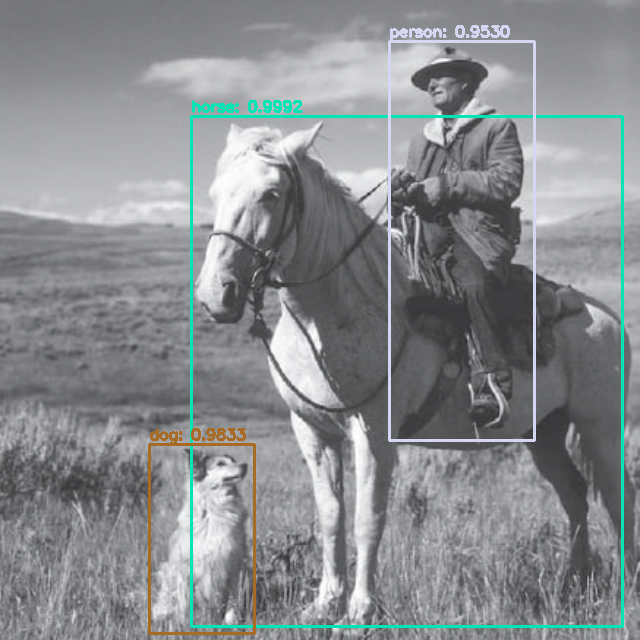

In [56]:
output_img = draw_bounding_boxes_yolo(img, indices, bounding_boxes, confidences, class_ids, BB_COLORS, LABELS)
cv2_imshow(output_img)

In [59]:
import time

start_time = time.time()
detector_outputs = model.forward(output_layers)

print(f"Time required to predict: {time.time() - start_time} seconds")

Time required to predict: 2.5890328884124756 seconds
